In [1]:
import gym
import torch
import random
import numpy as np
import torch
from PIL import Image
import torch
import torch.nn as nn
from collections import namedtuple
from collections import deque
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
from matplotlib.pyplot import imshow
from PIL import Image
from wrappers import make_atari, wrap_deepmind, wrap_pytorch
import queue
from torch import optim
import matplotlib.pyplot as plt

# Model

In [2]:
class QNet(torch.nn.Module):
    def __init__(self,obs_shape,act_shape,atoms):
        super(QNet, self).__init__()
        self.atoms = atoms
        self.act_shape = act_shape
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.relu = nn.ReLU()
        #Linear layers for dueling
        self.fc1 = nn.Linear(7*7*64,512)
        self.fc2 = nn.Linear(512,atoms)
        self.fc3 = nn.Linear(7*7*64,512)
        self.fc4 = nn.Linear(512,act_shape*atoms)
        self.softmax = nn.Softmax(dim=2)
    def forward(self, x):
        x=x/255
        #Conv
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = x.view(x.shape[0],-1)
        
        #Fc
        x1 = x
        x = self.fc1(x)
        x = self.relu(x)
        v = self.fc2(x)
        
        x1 = self.fc3(x1)
        x1 = self.relu(x1)
        adv = self.fc4(x1)
        
        #Reshaping value and advantage functions to add probabilities of each atom for each action
        value = v.view(v.shape[0],1,self.atoms)
        adv = adv.view(adv.shape[0],self.act_shape,self.atoms)
        
        q_s_a = value + adv - adv.mean(1,keepdim=True)
        
        #probability of each atom for all actions
        q_s_a = self.softmax(q_s_a)
        
        return q_s_a

In [3]:
def eps_greedy(epsilon,state,net,atoms):
    if(np.random.random()<epsilon):
        action = np.random.randint(ACT_SHAPE)
    else:
        #Finding the expected value of each action (sum(pi*zi))
        qvalues = net(state)
        expected_values = torch.matmul(qvalues,atoms)
        action = torch.argmax(expected_values).item()
    return action    

In [4]:
class ReplayBuffer(object):
    def __init__(self,maxsize):
        self.q = deque(maxlen = maxsize)
        self.maxsize = maxsize
    def add(self,x):
        self.q.append(x)
        if(len(self.q)==self.maxsize):
            self.q.popleft()
    def getSize(self):
        return len(self.q)
    def sample(self,size):
        batch = random.sample(list(self.q),size)
        state,action,reward,next_state,done = map(list, zip(*batch))
        return state,action,reward,next_state,done

# Loss function

In [5]:
def compute_loss(size,atoms):
    current_state,action,reward,next_state,done = buffer.sample(size)
    current_state = torch.stack(current_state)
    current_state = current_state.squeeze(1)
    next_state = torch.stack(next_state)
    next_state = next_state.squeeze(1)
    done = np.array(done)
    done = done.astype(int)
    reward = torch.Tensor(reward).cuda()
    action = torch.as_tensor(action).cuda()
    done = torch.Tensor(done).cuda()
    
    #qvalues -> (batch,actions,atoms)
    # z(xt)
    dist_current = net(current_state)
    
    # z(xt+1)
    dist_next = net(next_state)
    target_net.eval()
    
    # z'(xt+1)
    dist_target = target_net(next_state)
    
    #Selecting optimal action a*
    
    zvalues_next = torch.matmul(dist_next,atoms)
    optimal_action = zvalues_next.max(1)[1]
    
    #Distribution of target with optimal action z(xt+1,a*)
    dist_target_optimal = dist_target.gather(1,optimal_action.view(-1,1).unsqueeze(2).repeat(1,1,N_ATOMS))
    dist_target_optimal = dist_target_optimal.squeeze(1)
    
    #Finding target distribution values (Tzj = r + gamma*Z(x,a*)) (not aligned)
    done = done.squeeze(0)
    done = done.unsqueeze(1)
    Tz = reward.unsqueeze(1).repeat(1,N_ATOMS) + (1-done).repeat(1,N_ATOMS)*GAMMA*atoms.unsqueeze(0).repeat(size,1)
    
    #Clipping the values
    Tz = torch.clamp(Tz,min=VMIN,max=VMAX)
    
    #Aligning the values
    
    deltaz = (VMAX-VMIN)/(N_ATOMS-1)
    indices = (Tz - VMIN)/deltaz
    lower = indices.floor().long()
    upper = indices.ceil().long()
    #lower[(upper > 0) * (lower == upper)] -= 1
    #upper[(lower < (N_ATOMS - 1)) * (lower == upper)] += 1
    dm_l = (upper.float() + (lower == upper).float() - indices)*dist_target_optimal
    dm_u = (indices - lower.float())*dist_target_optimal
    
    #Finding target probabilities
    target_distribution = torch.zeros(size,N_ATOMS).cuda()
    
    for i in range(target_distribution.size(0)):
        target_distribution[i].index_add_(0,lower[i].long(),dm_l[i])
        target_distribution[i].index_add_(0,upper[i].long(),dm_u[i])
    
    
#     offset = torch.linspace(0, ((size - 1) * N_ATOMS), size).unsqueeze(1).expand(size, N_ATOMS).to(action).cuda()
    
#     target_distribution = target_distribution.view(-1).index_add_(0, (lower + offset).view(-1), (dist_target_optimal * dm_u).view(-1))  # m_l = m_l + p(s_t+n, a*)(u - b)
#     target_distribution = target_distribution.view(-1).index_add_(0, (upper + offset).view(-1), (dist_target_optimal* dm_l).view(-1))  # m_u = m_u + p(s_t+n, a*)(b - l) 
    
    #p(xt,at)
    current_distribution = dist_current.gather(1,action.view(-1,1).unsqueeze(2).repeat(1,1,N_ATOMS))
    current_distribution = current_distribution.squeeze(1)
    
    
    target_distribution = torch.reshape(target_distribution,(size,N_ATOMS))
    L = -(target_distribution*torch.log(current_distribution)).sum(dim=1).mean()
    
#     print('Loss: ',L.item())
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    
    return L

In [6]:
def update_target():
    target_net.load_state_dict(net.state_dict())

In [7]:
def epsilon_decay(ep):
    e = .1 + .99*np.exp(-ep/30000)
    return e

In [8]:
def addreward(id,item,filename):
    f=open(filename,'a+')
    f.write(str(id)+' '+str(item)+' '+'\n')
    f.close()

In [9]:
def addloss(id,loss,filename):
    f=open(filename,'a+')
    f.write(str(id)+' '+str(loss.item())+' '+'\n')
    f.close()

# Training

In [10]:
# env = gym.make('PongNoFrameskip-v4')
env    = make_atari('PongNoFrameskip-v4')
# env    = make_atari('Pong-v0')
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

print(env.observation_space)
print(env.action_space)


Box(4, 84, 84)
Discrete(6)


In [11]:
ITERATIONS = 1000000
epsilon = .99
OBS_SHAPE = env.observation_space.shape
ACT_SHAPE = env.action_space.n
REPLAY_SAMPLE = 20000
BATCH_SIZE = 32
GAMMA = .99
T_upd = 10000
N_ATOMS = 51
VMAX = 10
VMIN = -10
atoms = torch.linspace(VMIN,VMAX,N_ATOMS).cuda()

In [12]:
net = QNet(env.observation_space.shape,env.action_space.n,N_ATOMS)
net = net.cuda()
target_net = QNet(env.observation_space.shape,env.action_space.n,N_ATOMS)
target_net = target_net.cuda()
# update_target()
optimizer = optim.Adam(net.parameters(), lr=0.00025,eps = .0003125)

In [13]:
# net.load_state_dict(torch.load('dqn-model.pth'))
# target_net.load_state_dict(torch.load('dqn-model-target.pth'))
# optimizer = optim.Adam(net.parameters(), lr=0.00001)
update_target()

In [14]:
buffer = ReplayBuffer(100000)

episode_reward = 0
state = env.reset()
state = torch.Tensor(state).cuda()
state = state.unsqueeze(0)
count = 0
lossfile = './dueling-logs/losses.txt'
rewardsfile = './dueling-logs/rewards.txt'
losses = []
rewards = [] 
for i in tqdm(range(ITERATIONS)):
    epsilon = epsilon_decay(i)
    action = eps_greedy(epsilon,state,net,atoms)
    next_state, reward, done, info = env.step(action)
    
    next_state = torch.Tensor(next_state).cuda().unsqueeze(0)
    buffer.add((state,action,reward,next_state,done))
    episode_reward+=reward
    state=next_state
    if(buffer.getSize()>REPLAY_SAMPLE and i%4):
        loss = compute_loss(BATCH_SIZE,atoms)
        losses.append(loss)
#         if(i%500==0):
#             print(loss)
#             addloss(i,loss,lossfile)
    if done:
        count+=1
        rewards.append(episode_reward)
        print(count,episode_reward)
        
        #if(count%5==0):
#             addreward(count,episode_reward,rewardsfile)
            #print('ep',count,episode_reward)
        episode_reward = 0 
        state = env.reset()
        state = torch.Tensor(state).cuda()
        state = state.unsqueeze(0)
    if(i%T_upd==0):
#         torch.save(net.state_dict(),'./dueling-logs/dqn-model.pth')
#         torch.save(target_net.state_dict(),'./dueling-logs/dqn-model-target.pth')
        update_target()


/home/ishaan16238/.conda/envs/ishaan/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


1 -20.0
2 -18.0
3 -20.0
4 -20.0
5 -21.0
6 -20.0
7 -21.0
8 -21.0
9 -20.0
10 -21.0
11 -21.0
12 -20.0
13 -21.0
14 -21.0
15 -21.0
16 -21.0
17 -21.0
18 -21.0
19 -21.0
20 -21.0
21 -21.0
22 -21.0
23 -21.0
24 -21.0
25 -21.0
26 -20.0
27 -21.0
28 -20.0
29 -20.0
30 -19.0
31 -21.0
32 -19.0
33 -21.0
34 -21.0
35 -21.0
36 -21.0
37 -20.0
38 -21.0
39 -21.0
40 -20.0
41 -20.0
42 -21.0
43 -21.0
44 -20.0
45 -21.0
46 -21.0
47 -21.0
48 -21.0
49 -21.0
50 -20.0
51 -20.0
52 -20.0
53 -20.0
54 -19.0
55 -20.0
56 -20.0
57 -20.0
58 -21.0
59 -20.0
60 -19.0
61 -21.0
62 -21.0
63 -21.0
64 -20.0
65 -20.0
66 -19.0
67 -20.0
68 -21.0
69 -20.0
70 -20.0
71 -21.0
72 -21.0
73 -21.0
74 -20.0
75 -21.0
76 -21.0
77 -20.0
78 -20.0
79 -20.0
80 -21.0
81 -21.0
82 -21.0
83 -21.0
84 -21.0
85 -20.0
86 -20.0
87 -21.0
88 -21.0
89 -21.0
90 -20.0
91 -21.0
92 -20.0
93 -21.0
94 -21.0
95 -20.0
96 -21.0
97 -21.0
98 -21.0
99 -20.0
100 -20.0
101 -21.0
102 -21.0
103 -21.0
104 -21.0
105 -21.0
106 -21.0
107 -20.0
108 -21.0
109 -21.0
110 -20.0
111 -20.

KeyboardInterrupt: 

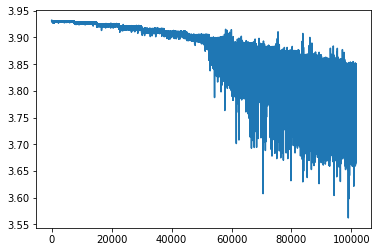

In [16]:
plt.plot(losses)

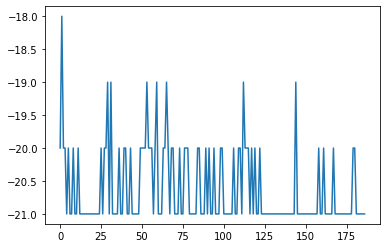

In [17]:
plt.plot(rewards)